Table 'mushroom_secondary_data.csv from: https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset  (12/07/2023) \
Wagner,Dennis, Heider,D., and Hattab,Georges. (2023). Secondary Mushroom Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5FP5Q. \
Observations: 61.069

Columns:
0. class: edible=e and poisonous=p 
1. cap-diameter (m): float number in cm
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o
3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e
4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f
6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?
7. gill-spacing (n): close=c, distant=d, none=f
8. gill-color (n): see cap-color + none=f
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm
11. stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e,
rhizomorphs=z, rooted=r
12. stem-surface (n): see cap-surface + none=f
13. stem-color (n): see cap-color + none=f
14. veil-type (n): partial=p, universal=u
15. veil-color (n): see cap-color + none=f
16. has-ring (n): ring=t, none=f
17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. spore-print-color (n): see cap color
19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d
20. season (n): spring=s, summer=u, autumn=a, winter=w


problemsn:
- cap-surface: 23% missing values
- gill-attachment: 16% missing values
- gill-spacing: 41% missing values
- stem-root: 84% missing values
- stem-surface: 62% missing values
- veil-type: 94% miss - There are a lot of missing, but it explains the target variableing values
- veil-color: 87% missing values
- ring-type: 4% missing values
- spore-print-color: 89% missing values
- duplicated values: 146

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import models
from keras import layers

2023-09-26 20:01:50.170825: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 20:01:50.624293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 20:01:51.565193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('mushroom_secondary_data.csv', sep = ";")
# Shuffle data
df = df.sample(frac = 1, random_state = 1).reset_index(drop = True)

# Remove duplicates
df = df[~df.duplicated()]

# Remove bad columns:
df.drop(['gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'spore-print-color'], axis = 1, inplace = True)

# Transforme class variable so edible is equals to 1 and 0 otherwise.
df['class'] = df.apply(lambda row:1 if row['class'] == 'e' else 0, axis = 1)

# fill missing values
df.fillna('missing', inplace = True)

# Define type as category
var_category = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed'
               , 'gill-attachment', 'gill-color', 'stem-color', 'veil-color', 'has-ring', 'ring-type'
               , 'habitat', 'season']

for col in var_category:
    df[col] = df[col].astype('category')
    
# df = df[0:10000]

display(df)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,veil-color,has-ring,ring-type,habitat,season
0,1,1.72,x,s,y,f,d,w,7.01,2.36,y,missing,f,f,h,u
1,1,9.59,f,e,b,f,missing,b,4.73,20.49,w,missing,t,f,d,a
2,0,0.86,x,g,p,f,a,p,4.25,1.05,k,missing,f,f,d,s
3,0,4.32,x,missing,e,f,x,w,4.91,6.58,w,missing,f,f,d,u
4,1,2.80,x,s,w,f,d,w,3.13,5.69,w,missing,f,f,m,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,0,13.81,x,k,n,t,p,y,10.06,31.63,y,missing,f,f,d,a
61065,0,2.69,x,d,w,f,d,p,3.76,2.41,w,missing,f,f,g,a
61066,1,11.70,f,missing,g,f,s,u,7.36,20.73,b,missing,f,f,l,a
61067,0,2.83,s,w,u,f,a,u,5.76,5.59,u,missing,f,f,d,a


In [3]:
# Split train, validation and test
df_train_aux, df_test = train_test_split(df, test_size = 0.10, random_state = 1, shuffle = True, stratify = df["class"])
df_train, df_val = train_test_split(df_train_aux, test_size = 0.10, random_state = 1, shuffle = True, stratify = df_train_aux["class"])
df_train.reset_index(drop = True, inplace = True)
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print(f'Train observations: {len(df_train)}')
print(f'Validation observations: {len(df_val)}')
print(f'Test observations: {len(df_test)}')

Train observations: 49347
Validation observations: 5483
Test observations: 6093


In [4]:
# scale and label encode the attributes. Not necessary for LightGBM, but essential for autoencoder. 
continuous_varibles = ['cap-diameter', 'stem-height', 'stem-width']
categorical_variables = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed'
               , 'gill-attachment', 'gill-color', 'stem-color', 'veil-color', 'has-ring', 'ring-type'
               , 'habitat', 'season']
scaler = StandardScaler()
label_encoder = {}
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[continuous_varibles]), columns = continuous_varibles)
for col in categorical_variables[1:]:
    label_encoder[col] = preprocessing.LabelEncoder()
    X_encoded = label_encoder[col].fit_transform(df_train[col])
    le_name_mapping = dict(zip(label_encoder[col].classes_, label_encoder[col].transform(label_encoder[col].classes_)))
    if 'missing' in le_name_mapping:
        X_encoded[X_encoded == le_name_mapping['missing']] = 9999   # All missing values in all columns will be mapped as 9999
    df_train_scaled[col] = X_encoded
df_train_scaled['class'] = df_train['class']

df_val_scaled = pd.DataFrame(scaler.transform(df_val[continuous_varibles]), columns = [continuous_varibles])
for col in categorical_variables[1:]:
    X_encoded = label_encoder[col].transform(df_val[col])
    if 'missing' in le_name_mapping:
        X_encoded[X_encoded == le_name_mapping['missing']] = 9999   # All missing values in all columns will be mapped as 9999 
    df_val_scaled[col] = X_encoded
df_val_scaled['class'] = df_val['class']

df_test_scaled = pd.DataFrame(scaler.transform(df_test[continuous_varibles]), columns = [continuous_varibles])
for col in categorical_variables[1:]:
    X_encoded = label_encoder[col].transform(df_test[col])
    if 'missing' in le_name_mapping:
        X_encoded[X_encoded == le_name_mapping['missing']] = 9999   # All missing values in all columns will be mapped as 9999 
    df_test_scaled[col] = X_encoded
df_test_scaled['class'] = df_test['class']

# One-hot encode
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_fit = ohe.fit(df_train_scaled[categorical_variables[1:]].values)
df_train_scaled_ohe = pd.DataFrame(ohe_fit.transform(df_train_scaled[categorical_variables[1:]].values).toarray(), columns = ohe_fit.get_feature_names_out(categorical_variables[1:]))
df_train_scaled_ohe = df_train_scaled[['class', 'cap-diameter', 'stem-height', 'stem-width']].join(df_train_scaled_ohe)

df_val_scaled_ohe = pd.DataFrame(ohe_fit.transform(df_val_scaled[categorical_variables[1:]].values).toarray(), columns = ohe_fit.get_feature_names_out(categorical_variables[1:]))
df_val_scaled_ohe = df_val_scaled.loc[:,['class', 'cap-diameter', 'stem-height', 'stem-width']].join(df_val_scaled_ohe)
df_val_scaled_ohe.columns = ['class', 'cap-diameter', 'cap-height' ,'cap-width'] + [x for x in range(0,96)]

df_test_scaled_ohe = pd.DataFrame(ohe_fit.transform(df_test_scaled[categorical_variables[1:]].values).toarray(), columns = ohe_fit.get_feature_names_out(categorical_variables[1:]))
df_test_scaled_ohe = df_test_scaled[['class', 'cap-diameter', 'stem-height', 'stem-width']].join(df_test_scaled_ohe)
df_test_scaled_ohe.columns = ['class', 'cap-diameter', 'cap-height' ,'cap-width'] + [x for x in range(0,96)]

# Drop missing column
missing_col = df_train_scaled_ohe.columns.to_series().str.contains('9999').values
df_train_scaled_ohe = df_train_scaled_ohe.iloc[:,~missing_col]
df_val_scaled_ohe = df_val_scaled_ohe.iloc[:,~missing_col]
df_test_scaled_ohe = df_test_scaled_ohe.iloc[:,~missing_col]


df_train_scaled_ohe

,class,cap-diameter,stem-height,stem-width,cap-shape_0,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,...,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6,habitat_7,season_0,season_1,season_2,season_3
0,0,-0.888365,-0.524769,-1.042184,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.466723,0.548964,0.255466,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,-0.662517,-1.031809,-0.970148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,-0.844714,0.003150,-0.827076,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0.703959,-0.157910,0.474576,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49342,0,-0.901650,0.367026,-0.929128,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49343,1,-1.097132,-0.432309,-1.127227,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49344,1,0.442051,-0.035624,-0.193759,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49345,0,0.193428,-0.077380,-0.237781,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Creates dataframes with missing values

In [5]:
def make_missing_values(df):
    df_continuous = df.iloc[:, 0:3].copy()  # Continuous variables
    df_categorical = df.iloc[:, 3:].copy()  # categorical variables
    # Set missing values for all categorical variables
    df_dict = {}
    df_original_dict = {}
    missing_percent = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
            
    for e in missing_percent:
        missing_mask = np.random.binomial(1, 1 - e, df_categorical.shape)
        df_original_dict[e] = df.copy() 
        df_dict[e] = df_categorical.copy() * missing_mask
        df_dict[e] = pd.merge(df_continuous, df_dict[e], left_index = True, right_index = True)
    return df_dict, df_original_dict

X_train = df_train_scaled_ohe.drop(['class'], axis = 1)
# Set missing values for all categorical variables
X_train_missing, df_train_original_dict = make_missing_values(X_train.copy())
y_train = df_train_scaled_ohe['class']

X_val = df_val_scaled_ohe.drop(['class'], axis = 1)
# Set missing values for all categorical variables
X_val_missing, df_val_original_dict = make_missing_values(X_val.copy())
y_val = df_val_scaled_ohe['class']

X_test = df_test_scaled_ohe.drop(['class'], axis = 1)
# Set missing values for all categorical variables
X_test_missing, df_test_original_dict = make_missing_values(X_test.copy())
y_test = df_test_scaled_ohe['class']

X_train_missing[0.5]

,cap-diameter,stem-height,stem-width,cap-shape_0,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-shape_6,...,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6,habitat_7,season_0,season_1,season_2,season_3
0,-0.888365,-0.524769,-1.042184,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.466723,0.548964,0.255466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.662517,-1.031809,-0.970148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.844714,0.003150,-0.827076,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.703959,-0.157910,0.474576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49342,-0.901650,0.367026,-0.929128,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49343,-1.097132,-0.432309,-1.127227,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49344,0.442051,-0.035624,-0.193759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49345,0.193428,-0.077380,-0.237781,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
def bootstrap_sample(X_var, y_var, X_var_full, random_state):
    # Make bootstrap and separate data into X_train, y_train, X_val, y_val
    X_var_bootstrap = X_var.sample(len(X_var), replace = True, random_state = random_state).copy()
    y_train_bootstrap = y_var[X_var_bootstrap.index].copy()
    X_var_full = X_var_full.iloc[X_var_bootstrap.index.to_list()]  # X without missing values.
    return X_var_bootstrap, y_train_bootstrap, X_var_full

In [7]:
# Model LightGBM
# edible = 1
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 5000,
            "min_data_in_leaf": 1000,
            "max_depth": 10,
            "feature_fraction": 0.5,
            "learning_rate": 0.01}  

n_bootstrap = 10
list_accuracy_lgbm_train = []
list_accuracy_lgbm_test = []
list_accuracy_with_autoencoder_train = []
list_accuracy_with_autoencoder_test = []
run_missing_percent = []
# missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
missing_percent = [0.8, 0.85, 0.9]
for e in missing_percent:
    list_accuracy_lgbm_bootstrap_train = []
    list_accuracy_lgbm_bootstrap_test = []
    list_accuracy_with_autoencoder_bootstrap_train = []
    list_accuracy_with_autoencoder_bootstrap_test = []
    for boots_i in range(n_bootstrap):
        # Train with bootstrap
        X_train_bootstrap, y_train_bootstrap, X_train_full_bootstrap = bootstrap_sample(X_var = X_train_missing[e].copy(), y_var = y_train.copy()
                                                                                        , X_var_full = df_train_original_dict[e].copy(), random_state = boots_i)
        
        # Input median for missing values
        X_train_aux = X_train_bootstrap.copy()
        # median = X_train_aux.median()
        # X_train_aux = X_train_aux.fillna(median)  # Not necessary in this case.

        X_test_aux = X_test_missing[e].copy()
        # X_test_aux = X_test_aux.fillna(median)    # Not necessary in this case.
    
        # Fit model LightGBM
        lightgbm_aux_fit = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_train_aux, y_train_bootstrap)
        # Predict LightGBM
        y_pred_prob_train_aux = lightgbm_aux_fit.predict_proba(X_train_aux)[:,1]
        y_pred_train_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_aux]
        
        y_pred_prob_test_aux = lightgbm_aux_fit.predict_proba(X_test_aux)[:,1]
        y_pred_test_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_aux]

        # Append results bootstrap LightGBM
        list_accuracy_lgbm_bootstrap_train.append(accuracy_score(y_train_bootstrap, y_pred_train_aux))
        list_accuracy_lgbm_bootstrap_test.append(accuracy_score(y_test, y_pred_test_aux))

        # Use denoising autoencoder
        # Sets with noise
        X_train_aux = X_train_bootstrap.copy()
        X_test_aux = X_test_missing[e].copy()
        
        # Sets without noise
        X_train_original = X_train_full_bootstrap.copy()
        X_train_continuous_original = X_train_original.iloc[:,0:3].copy()
        X_train_category_original = X_train_original.iloc[:,3:].copy()
        
        X_test_original = df_test_original_dict[e].copy()
        X_test_continuous_original = X_test_original.iloc[:,0:3].copy()
        X_test_category_original = X_test_original.iloc[:,3:].copy()

        # Autoencoder
        input_shape = X_train_aux.shape[1]
        output_continuous_shape = X_train_continuous_original.shape[1]
        output_category_shape = X_train_category_original.shape[1]
        
        tf.keras.backend.clear_session()
        inputs = tf.keras.layers.Input(shape=(input_shape,))  
        encoder_1 = layers.Dense(units = 93, activation = 'relu')(inputs)  
        encoder_2_continuous =  layers.Lambda(lambda x: x[:, 0: output_continuous_shape])(encoder_1)
        encoder_2_category_aux =  layers.Lambda(lambda x: x[:, output_continuous_shape: ])(encoder_1)
        encoder_2_category = layers.Dense(units = 90, activation = 'sigmoid')(encoder_2_category_aux)  
        encoder_3 = layers.Concatenate(axis=1)([encoder_2_continuous, encoder_2_category])
        
        decoder_1 = layers.Dense(units = 93, activation = 'relu')(encoder_3)  
        decoder_2_continuous =  layers.Lambda(lambda x: x[:, 0: output_continuous_shape], name = 'decoder_2_continuous')(decoder_1)
        decoder_2_category_aux =  layers.Lambda(lambda x: x[:, output_continuous_shape: ])(decoder_1)
        decoder_2_category = layers.Dense(units = output_category_shape, activation = 'sigmoid', name = 'decoder_2_category')(encoder_2_category_aux) 
        
        
        model_autoencoder = models.Model(inputs = inputs, outputs = [decoder_2_continuous, decoder_2_category])
        model_autoencoder.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.05),
                                   loss = {'decoder_2_continuous': 'mse', 
                                           'decoder_2_category': 'binary_crossentropy'},
                                   metrics = {'decoder_2_continuous': 'mse', 
                                              'decoder_2_category': 'binary_accuracy'}
                                 )
        
        
        model_1_history = model_autoencoder.fit(X_train_aux, (X_train_continuous_original, X_train_category_original)
                                                , verbose = 0
                                                , epochs = 100)

        # Define encoder model
        model_encoder = models.Model(inputs = inputs, outputs = encoder_3)

        # Get codings
        codings_X_train = pd.DataFrame(model_encoder.predict(X_train_aux))
        for col in codings_X_train.columns:
            codings_X_train[col] = np.where(codings_X_train[col] > 0.5, 1, 0)
            
        codings_X_test = pd.DataFrame(model_encoder.predict(X_test_aux))
        for col in codings_X_test.columns:
            codings_X_test[col] = np.where(codings_X_test[col] > 0.5, 1, 0)

        # LightGBM with autoencoder       
        lightgbm_fit_2_aux = lgb.LGBMClassifier(**hyperparameters_dict).fit(codings_X_train, y_train_bootstrap)
        y_pred_prob_train_2_aux = lightgbm_fit_2_aux.predict_proba(codings_X_train)[:,1]
        y_pred_train_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_2_aux]
        
        y_pred_prob_test_2_aux = lightgbm_fit_2_aux.predict_proba(codings_X_test)[:,1]
        y_pred_test_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_2_aux]
        
        # Append results bootstrap LightGBM with autoencoder
        list_accuracy_with_autoencoder_bootstrap_train.append(accuracy_score(y_train_bootstrap, y_pred_train_2_aux))
        list_accuracy_with_autoencoder_bootstrap_test.append(accuracy_score(y_test, y_pred_test_2_aux))

    # Append results after bootstrap
    list_accuracy_lgbm_train.append(list_accuracy_lgbm_bootstrap_train)
    list_accuracy_lgbm_test.append(list_accuracy_lgbm_bootstrap_test)
    list_accuracy_with_autoencoder_train.append(list_accuracy_with_autoencoder_bootstrap_train)
    list_accuracy_with_autoencoder_test.append(list_accuracy_with_autoencoder_bootstrap_test)
    run_missing_percent.append(e)
    df_run_missing_percent = pd.DataFrame(list(zip(run_missing_percent,
                                                  list_accuracy_lgbm_train,
                                                  list_accuracy_lgbm_test,
                                                  list_accuracy_with_autoencoder_train,
                                                  list_accuracy_with_autoencoder_test)),
                                          columns = ['percent',
                                                   'accuracy_lgbm_train',
                                                   'list_accuracy_lgbm_test',
                                                   'list_accuracy_with_autoencoder_train',
                                                   'list_accuracy_with_autoencoder_test'])
    df_run_missing_percent.to_csv('df_run_missing_percent.csv')
    
    

/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
2023-09-26 20:02:02.561280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4421 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
2023-09-26 20:02:03.391119: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f5808e430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-26 20:02:03.391152: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-09-26 20:02:03.489876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-26 20:02:03.

191/191 [==============================] - 0s 471us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 434us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 452us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 457us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 460us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 425us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 452us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 440us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 424us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 475us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 424us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 470us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 426us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 466us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 503us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 417us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 462us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 434us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 419us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 437us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 437us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 446us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 441us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 429us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 436us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 426us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 455us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 414us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 428us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


191/191 [==============================] - 0s 435us/step


/home/max/miniconda3/envs/e82_autoencoder/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [11]:
df_run_missing_percent_075 = pd.read_csv('df_run_missing_percent 0 to 075.csv')
df_run_missing_percent_08_09 = pd.read_csv('df_run_missing_percent 08 to 09.csv')
df_run_missing_percent = pd.concat([df_run_missing_percent_075, df_run_missing_percent_08_09], ignore_index = True)
df_run_missing_percent

,Unnamed: 0,percent,accuracy_lgbm_train,list_accuracy_lgbm_test,list_accuracy_with_autoencoder_train,list_accuracy_with_autoencoder_test
0,0,0.05,"[0.9985409447382819, 0.9983990921433927, 0.998...","[0.995240439849007, 0.9939274577383883, 0.9945...","[0.9640302348673678, 0.9790058159563905, 0.988...","[0.9491219432135237, 0.9637288691941572, 0.973..."
1,1,0.10,"[0.9961091859687519, 0.9959875980302754, 0.995...","[0.9876907927129492, 0.9881831610044313, 0.988...","[0.9657527306624516, 0.9770604089407664, 0.968...","[0.9453471196454948, 0.9519120301985885, 0.944..."
2,2,0.15,"[0.9907998459886113, 0.9916509615579467, 0.991...","[0.9806335138683735, 0.9809617593960283, 0.980...","[0.9486898899629157, 0.9710215413297667, 0.946...","[0.9204004595437387, 0.9494501887411784, 0.918..."
3,3,0.20,"[0.9858350051674873, 0.9855512999777089, 0.985...","[0.9776793041194813, 0.9791564089939274, 0.976...","[0.9351328348227855, 0.9285670861450545, 0.920...","[0.9082553750205153, 0.8980797636632201, 0.895..."
4,4,0.25,"[0.9770806735971792, 0.9781749650434677, 0.976...","[0.9634006236665026, 0.9624158870835385, 0.962...","[0.9314041380428395, 0.9227106004417696, 0.941...","[0.901854587231249, 0.8880682750697522, 0.9067..."
5,5,0.30,"[0.9683060773704582, 0.9709810120169412, 0.968...","[0.9543738716559987, 0.954045626128344, 0.9538...","[0.9004397430441566, 0.9355786572638661, 0.892...","[0.8728048580338092, 0.8943049400951912, 0.866..."
6,6,0.35,"[0.9573428982511601, 0.9582953371025594, 0.959...","[0.9410799277859839, 0.9409158050221565, 0.942...","[0.9180497294668369, 0.9248789186779338, 0.926...","[0.8741178401444281, 0.880354505169867, 0.8882..."
7,7,0.40,"[0.9472510993576104, 0.9462986605062111, 0.945...","[0.9274577383883145, 0.9271294928606598, 0.926...","[0.900338419762093, 0.8682999979735344, 0.9092...","[0.8547513540128016, 0.828163466272772, 0.8600..."
8,8,0.45,"[0.9310799035402355, 0.932417370863477, 0.9324...","[0.90858362054817, 0.9108813392417529, 0.90579...","[0.8848359576063388, 0.8613694854803737, 0.858...","[0.8296405711472181, 0.822911537830297, 0.8250..."
9,9,0.50,"[0.9174417897744543, 0.9179484061847731, 0.918...","[0.8910224848186443, 0.890365993763335, 0.8916...","[0.863213569213934, 0.8531622996332097, 0.8502...","[0.804693911045462, 0.8120794354176925, 0.8004..."


In [44]:
list_accuracy_lgbm_train = []
list_accuracy_lgbm_test = []
list_accuracy_with_autoencoder_train =[]
list_accuracy_with_autoencoder_test = []
for i in range(len(df_run_missing_percent)):
    list_accuracy_lgbm_train.append(df_run_missing_percent.iloc[i].accuracy_lgbm_train.translate({ord(x): '' for x in chars_to_remove}).split(','))
    list_accuracy_lgbm_test.append(df_run_missing_percent.iloc[i].list_accuracy_lgbm_test.translate({ord(x): '' for x in chars_to_remove}).split(','))
    list_accuracy_with_autoencoder_train.append(df_run_missing_percent.iloc[i].list_accuracy_with_autoencoder_train.translate({ord(x): '' for x in chars_to_remove}).split(','))
    list_accuracy_with_autoencoder_test.append(df_run_missing_percent.iloc[i].list_accuracy_with_autoencoder_test.translate({ord(x): '' for x in chars_to_remove}).split(','))

# Transform values from string to float
for i in range(len(list_accuracy_lgbm_train)):
    for j in range(len(list_accuracy_lgbm_train[i])):
        list_accuracy_lgbm_train[i][j] = float(list_accuracy_lgbm_train[i][j])
        list_accuracy_lgbm_test[i][j] = float(list_accuracy_lgbm_test[i][j])
        list_accuracy_with_autoencoder_train[i][j] = float(list_accuracy_with_autoencoder_train[i][j])
        list_accuracy_with_autoencoder_test[i][j] = float(list_accuracy_with_autoencoder_test[i][j])

In [45]:
# Collect mean and standard deviation from the performance metrics
list_accuracy_lgbm_test_mean = []
list_accuracy_lgbm_test_std = []
list_accuracy_with_autoencoder_test_mean = []
list_accuracy_with_autoencoder_test_std = []
for i in range(len(list_accuracy_lgbm_test)):
    list_accuracy_lgbm_test_mean.append(np.mean(list_accuracy_lgbm_test[i]))
    list_accuracy_lgbm_test_std.append(np.std(list_accuracy_lgbm_test[i]))
    list_accuracy_with_autoencoder_test_mean.append(np.mean(list_accuracy_with_autoencoder_test[i]))
    list_accuracy_with_autoencoder_test_std.append(np.std(list_accuracy_with_autoencoder_test[i]))

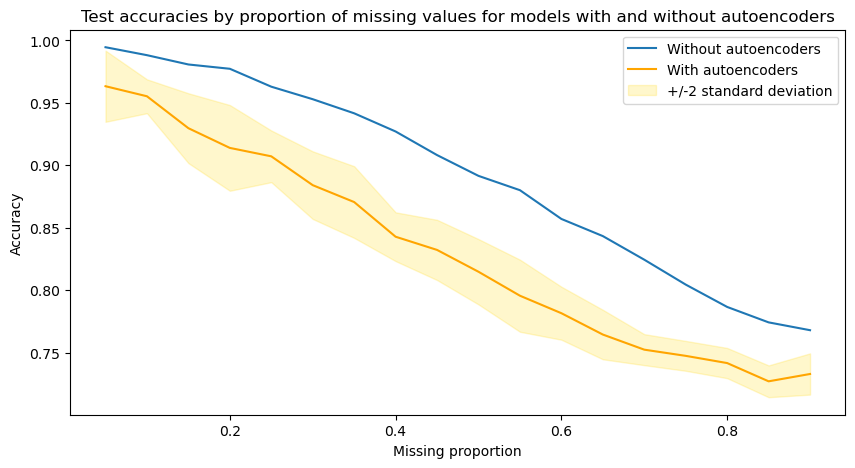

In [49]:
missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(missing_percent, list_accuracy_lgbm_test_mean, label = 'Without autoencoders')
axes.plot(missing_percent, list_accuracy_with_autoencoder_test_mean, color = 'orange', label = 'With autoencoders')
# +/- 2 standard deviation from test
axes.fill_between(missing_percent, list_accuracy_with_autoencoder_test_mean + 2*np.array(list_accuracy_with_autoencoder_test_std)
                  , list_accuracy_with_autoencoder_test_mean - 2*np.array(list_accuracy_with_autoencoder_test_std)
                  , color = 'gold', alpha=0.2, label = '+/-2 standard deviation')
axes.set_xlabel('Missing proportion')
axes.set_ylabel('Accuracy')
axes.set_title("Test accuracies by proportion of missing values for models with and without autoencoders")
axes.legend()

plt.show()
plt.close();